## **Loading data**

In [ ]:
!mkdir Data
!mkdir Data/baseline_catboost

!wget https://storage.yandexcloud.net/datasouls-ods/materials/0433a4ca/transactions.zip -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/0554f0cf/clickstream.zip -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/acfacf11/train_matching.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/b949c04c/mcc_codes.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/705abbab/click_categories.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/e33f2201/currency_rk.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/b99fed70/puzzle.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/f76e8087/sample_submission.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/24687252/baseline_catboost.zip -P Data
    
!unzip Data/transactions.zip -d Data
!unzip Data/clickstream.zip -d Data
!unzip Data/baseline_catboost.zip -d Data/baseline_catboost

!rm Data/transactions.zip
!rm Data/clickstream.zip
!rm Data/baseline_catboost.zip

A subdirectory or file Data already exists.
The syntax of the command is incorrect.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program 

## **Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle
import sys
import warnings
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

colors = sns.cubehelix_palette(start=.5, rot=-.5)
palette = plt.get_cmap('cubehelix')
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings('ignore')

**LAMA libraries**

In [2]:
# Imports from LightAutoML package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
from autowoe import AutoWoE
from lightautoml.automl.presets.whitebox_presets import WhiteBoxPreset

In [2]:
# constants
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 13
TEST_SIZE = 0.2
TIMEOUT = 1200
TARGET_NAME = 'higher_education'
np.random.seed(RANDOM_STATE)

In [2]:
# вспомогательная функция для контроля за памятью
from psutil import virtual_memory
ram_gb = round(virtual_memory().total / 1024**3, 1)
def print_memory():
    print('memory used', round(virtual_memory().used/1024/1024/1024,2), 'Gb', end = ' | ')
    print('memory available', round(virtual_memory().available/1024/1024/1024,2), 'Gb', end = ' | ')
    print('memory available', round(virtual_memory().available * 100 / virtual_memory().total,2), 'percent')

In [3]:
all_dicts = {}

In [4]:
print_memory()

memory used 3.11 Gb | memory available 8.79 Gb | memory available 73.85 percent


## **Reading and proccesing data**

### **Main files**

In [5]:
# reading data
#transactions = pd.read_csv('C:\Coding\Python\Data-Science\Competitions\Data Fusion Contest 2022. Puzzle\Data/transactions.csv')
clickstream = pd.read_csv('C:\Coding\Python\Data-Science\Competitions\Data Fusion Contest 2022. Puzzle\Data\clickstream.csv')

In [9]:
print('Transactions:\n',transactions.dtypes, '\n', '\nClickstream:\n', clickstream.dtypes)

Transactions:
 user_id              object
mcc_code              int64
currency_rk           int64
transaction_amt     float64
transaction_dttm     object
dtype: object 
 
Clickstream:
 user_id      object
cat_id        int64
timestamp    object
new_uid       int64
dtype: object


In [6]:
# transform "object" for transaction_dttm, timestamp to datetime type

#transactions['transaction_dttm'] = pd.to_datetime(transactions['transaction_dttm'])
clickstream['timestamp'] = pd.to_datetime(clickstream['timestamp'])

#### **Clickstream**

In [11]:
print('Shape of clickstream: ', clickstream.shape)
clickstream.head(2)

Shape of clickstream:  (126752515, 4)


user_id  cat_id           timestamp  new_uid
0  000143baebad4467a23b98c918ccda19     165 2021-01-30 20:08:12  1873448
1  000143baebad4467a23b98c918ccda19     165 2021-01-31 20:06:29  1873448

In [12]:
for col in clickstream:
    print(col, '\t', clickstream[col].nunique(), '\t', clickstream[col].min(), ' - ', clickstream[col].max())

user_id 	 19623 	 000143baebad4467a23b98c918ccda19  -  ffff8348710b49c78ffa8c13b00b22f4
cat_id 	 402 	 1  -  1861
timestamp 	 5840311 	 2021-01-17 18:42:39  -  2021-08-14 22:41:59
new_uid 	 81285 	 21  -  1873964


*In file clickstream.csv 126.7 millions rows, 19623 unique clients, 402 unique categories and 81285 unique devices. Time - mid-January to mid-August 2021*

In [7]:
# data reduction by encoding
all_dicts['rtk_le'] = LabelEncoder().fit(clickstream['user_id'])
clickstream['user_id'] = all_dicts['rtk_le'].transform(clickstream['user_id'])+1
clickstream_dtypes = {'user_id':np.int16, 'cat_id':np.int16, 'new_uid':np.int32}
clickstream = clickstream.astype(clickstream_dtypes)

In [14]:
print('For each RTC user, there is ', round(clickstream.shape[0] / clickstream['user_id'].nunique(),1), ' unique entries')
print('For each RTC user, there is ', round(clickstream['new_uid'].nunique() / clickstream['user_id'].nunique(),1), ' unique devices')

For each RTC user, there is  6459.4  unique entries
For each RTC user, there is  4.1  unique devices


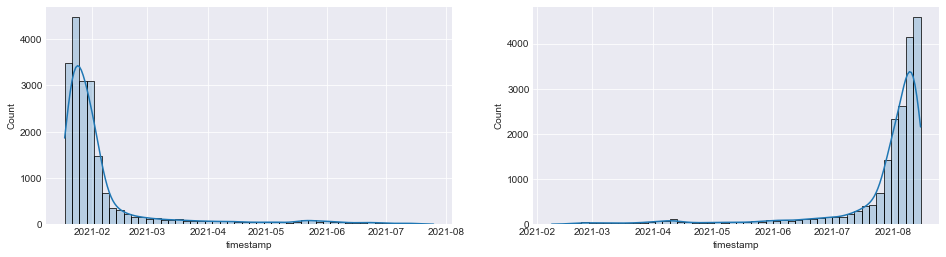

In [13]:
# Let's look at the distribution of the start and end times of customer activity
fig, axes = plt.subplots(1,2, figsize = (16,4))
sns.histplot(clickstream.groupby('user_id')['timestamp'].min(), bins= 50, ax = axes[0], kde = True, alpha = 0.25, palette = palette)
sns.histplot(clickstream.groupby('user_id')['timestamp'].max(), bins= 50, ax = axes[1], kde = True, alpha = 0.25, palette = palette);

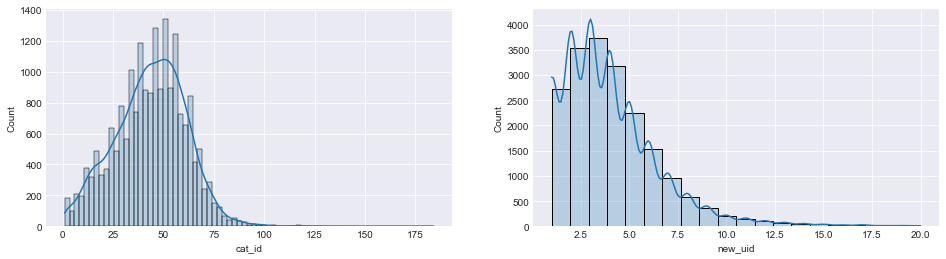

In [14]:
# Let's look at the distribution of the number of unique categories and devices for each client
fig, axes = plt.subplots(1,2, figsize = (16,4))
sns.histplot(clickstream.groupby('user_id')['cat_id'].agg(pd.Series.nunique), palette=palette, kde = True, alpha = 0.25, bins = 75, ax = axes[0])
t = clickstream.groupby('user_id')['new_uid'].agg(pd.Series.nunique)
sns.histplot(t[t<21],bins=20,palette=palette, kde = True, alpha = 0.25, ax = axes[1]);

In [15]:
print('Clickstream by cat_id info:\n', clickstream.groupby('user_id')['cat_id'].agg(pd.Series.nunique).describe(), '\n')
print('Clickstream by new_uid info:\n', clickstream.groupby('user_id')['new_uid'].agg(pd.Series.nunique).describe())

Clickstream by cat_id info:
 count    19623.000000
mean        43.679254
std         17.641016
min          1.000000
25%         32.000000
50%         45.000000
75%         56.000000
max        184.000000
Name: cat_id, dtype: float64 

Clickstream by new_uid info:
 count    19623.000000
mean         4.142333
std          5.156828
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        419.000000
Name: new_uid, dtype: float64


#### **Transactions**

In [15]:
print('Shape of transactions: ', transactions.shape)
transactions.head(2)

Shape of transactions:  (19821910, 5)


user_id  mcc_code  currency_rk  transaction_amt  \
0  000932580e404dafbecd5916d4640938      5411           48       -361.07230   
1  000932580e404dafbecd5916d4640938      5499           48       -137.31398   

     transaction_dttm  
0 2020-08-03 08:05:23  
1 2020-08-05 01:27:40

In [16]:
for col in transactions:
    print(col, '\t', transactions[col].nunique(), '\t', transactions[col].min(), ' - ', transactions[col].max())

user_id 	 22533 	 000932580e404dafbecd5916d4640938  -  fffb051877b949f49bed6538393a06ae
mcc_code 	 386 	 -1  -  9406
currency_rk 	 4 	 -1  -  60
transaction_amt 	 17063000 	 -230044.03  -  346395.34
transaction_dttm 	 12787367 	 2020-07-17 18:59:38  -  2021-08-14 21:13:26


*In file transactions.csv 19.8 millions rows, 22533 unique clients, 386 unique mcc_codes and 4 unique currencies. Time - mid-July 2020 to mid-August 2021*

In [9]:
# data size reduction by encoding
all_dicts['bank_le'] = LabelEncoder().fit(transactions['user_id'])
transactions['user_id'] = all_dicts['bank_le'].transform(transactions['user_id'])+1
transactions_dtypes = {'user_id':np.int16, 'mcc_code':np.int16, 'currency_rk':np.int8}
transactions = transactions.astype(transactions_dtypes)

In [18]:
print('For each bank user, there is ', round(transactions.shape[0] / transactions['user_id'].nunique(),1), ' unique entries')

For each bank user, there is  879.7  unique entries


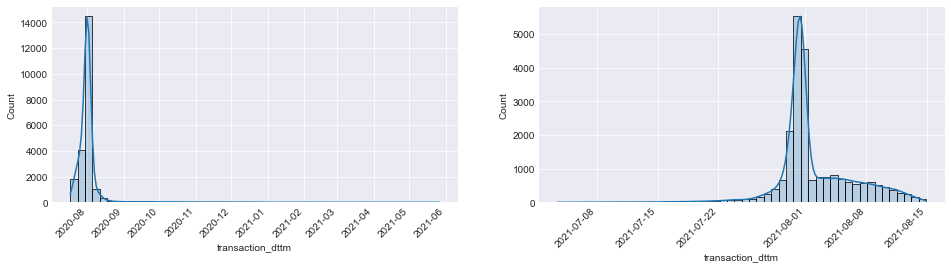

In [20]:
# Let's look at the distribution of the start and end times of customer activity
fig, axes = plt.subplots(1,2, figsize = (16,4))
fig.autofmt_xdate(rotation=45 )
sns.histplot(transactions.groupby('user_id')['transaction_dttm'].min(), bins= 50, ax = axes[0], kde = True, alpha = 0.25, palette = palette)
sns.histplot(transactions.groupby('user_id')['transaction_dttm'].max(), bins= 50, ax = axes[1], kde = True, alpha = 0.25, palette = palette);

In [21]:
# frequency of currency
transactions.currency_rk.value_counts()

 48    19765158
-1        27405
 50       20364
 60        8983
Name: currency_rk, dtype: int64

<AxesSubplot:xlabel='transaction_amt', ylabel='Count'>

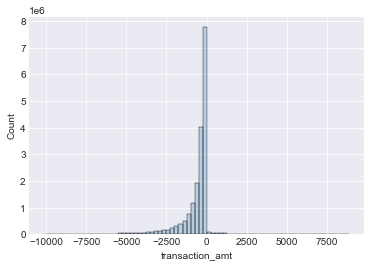

In [22]:
# Distribution transaction_amt
std = transactions['transaction_amt'].std()
mean = transactions['transaction_amt'].mean()
ind = (transactions['transaction_amt']>=mean-std)&(transactions['transaction_amt']<=mean+std)
data = transactions.loc[ind, 'transaction_amt']
sns.histplot( data, bins= 75, alpha = 0.25, palette = palette)

<AxesSubplot:xlabel='mcc_code', ylabel='Count'>

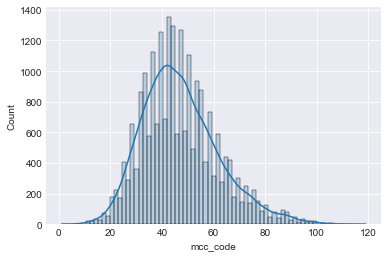

In [23]:
# Distribution unique categories (mcc_codes)
sns.histplot(transactions.groupby('user_id')['mcc_code'].agg(pd.Series.nunique), palette=palette, kde = True, alpha = 0.25, bins = 75)

In [24]:
print('Transactions by mcc_code info:\n', transactions.groupby('user_id')['mcc_code'].agg(pd.Series.nunique).describe(), '\n')

Transactions by mcc_code info:
 count    22533.000000
mean        47.171393
std         14.893906
min          1.000000
25%         37.000000
50%         45.000000
75%         56.000000
max        119.000000
Name: mcc_code, dtype: float64 



#### **Train_matching**

In [10]:
train_matching = pd.read_csv('C:\Coding\Python\Data-Science\Competitions\Data Fusion Contest 2022. Puzzle\Data/train_matching.csv')
print(train_matching.shape)
train_matching.head(2)

(17581, 2)


bank                               rtk
0  178b387813ac4a63a2200274a9e3876e  e19c0f141e9442c5bdb0d5751f6fba1c
1  47cffa46e6b04389ba91a70735d2c3ff  7df3371aabd349e4ac2de8299238627d

In [11]:
train_matching['bank'] = all_dicts['bank_le'].transform(train_matching['bank'])+1

train_matching.loc[train_matching.rtk == '0', 'rtk'] = 0
train_matching.loc[train_matching.rtk != 0, 'rtk'] = all_dicts['rtk_le'].transform(train_matching.loc[train_matching.rtk!=0, 'rtk'])+1

train_matching_dtypes = {'bank':np.int16, 'rtk':np.int16}
train_matching = train_matching.astype(train_matching_dtypes)

print('There are ', train_matching.bank.nunique(), 'bank clients in the ''train'' file, of which', train_matching.rtk.nunique(), 'have matches with RTK clients.')

There are  17581 bank clients in the train file, of which 14672 have matches with RTK clients.


### **Additional files**

#### **Categories**

In [8]:
click_categories = pd.read_csv('C:\Coding\Python\Data-Science\Competitions\Data Fusion Contest 2022. Puzzle\Data\click_categories.csv')
print(click_categories.shape)
click_categories[:10]

(402, 4)


cat_id               level_0       level_1 level_2
0       1           accessories           NaN     NaN
1       2           accessories      handbags     NaN
2       3           accessories     jewellery     NaN
3       8           accessories       watches     NaN
4      11                   age    age_0-5_yo     NaN
5      12                   age  age_17-23_yo     NaN
6      13                   age   age_6-16_yo     NaN
7      14                 audio           NaN     NaN
8      15  avid_music_listeners           NaN     NaN
9      19  avid_music_listeners         radio     NaN

In [9]:
click_categories.fillna('', inplace=True)
for col in click_categories:
    print(f"{col:<10}",click_categories[col].nunique() )

cat_id     402
level_0    85
level_1    280
level_2    56


In [ ]:
click_categories.groupby('level_0')

In [38]:
for i in range(5):
    print(
        'level_0:',f"{click_categories['level_0'].value_counts().index[i]:<20}",
        f"{click_categories['level_0'].value_counts()[i]:<10}",
        
        'level_1:',f"{click_categories['level_1'].value_counts().index[i]:<20}", '\t',
        f"{click_categories['level_1'].value_counts()[i]:<10}",

        'level_2:',f"{click_categories['level_2'].value_counts().index[i]:<20}", '\t',
        f"{click_categories['level_2'].value_counts()[i]:<10}",
    )


level_0: public_services      24         level_1:                      	 81         level_2:                      	 347       
level_0: health               23         level_1: school_education     	 6          level_2: body_treatments      	 1         
level_0: occupation           22         level_1: household_services   	 6          level_2: utilities_sector     	 1         
level_0: education            17         level_1: business_automation  	 4          level_2: orphanage            	 1         
level_0: cars                 15         level_1: farming              	 4          level_2: cigarettes           	 1         


#### **Mcc_code**

In [13]:
mcc = pd.read_csv('C:\Coding\Python\Data-Science\Competitions\Data Fusion Contest 2022. Puzzle\Data\mcc_codes.csv')
print(mcc.shape)
mcc.head(2)

(385, 3)


MCC                          Название  \
0  742               Ветеринарные услуги   
1  763  Сельскохозяйственные кооперативы   

                                            Описание  
0  Лицензированные специалисты в основном занимаю...  
1  Ассоциации и кооперативы, которые предоставляю...

In [14]:
mcc.fillna('', inplace=True)
for col in mcc:
    print(f"{col:<10}",mcc[col].nunique() )

MCC        385
Название   378
Описание   290


In [41]:
for i in range(5):
    print(
        f"{mcc['Название'].value_counts().index[i]:<50}",
        f"{mcc['Название'].value_counts()[i]:<50}",
    )


Отели, мотели, курорты                             7                                                 
Денежные переводы                                  2                                                 
Ветеринарные услуги                                1                                                 
Квази-Кэш – Нефинансовые учреждения                1                                                 
Финансовые учреждения – торговля и услуги          1                                                 


#### **Currency**

In [14]:
currency = pd.read_csv('C:\Coding\Python\Data-Science\Competitions\Data Fusion Contest 2022. Puzzle\Data\currency_rk.csv')
print(currency.shape)
currency

(3, 2)


currency_rk Name
0           48  RUR
1           50  USD
2           60  EUR

#### **Train**

In [15]:
train = pd.read_csv('C:\Coding\Python\Data-Science\Competitions\Data Fusion Contest 2022. Puzzle\Data/train_educational_only.csv')
print(train.shape)
train['bank'] = all_dicts['bank_le'].transform(train['bank'])+1

(8509, 2)


In [97]:
train.head()

bank  higher_education
0   4879               0.0
1   8515               0.0
2   7443               1.0
3  20952               0.0
4   2163               0.0

## **Enconding data**

### **Vectorize features** 

In [16]:
transactions.head(3)

user_id  mcc_code  currency_rk  transaction_amt    transaction_dttm
0        1      5411           48       -361.07230 2020-08-03 08:05:23
1        1      5499           48       -137.31398 2020-08-05 01:27:40
2        1      5499           48       -138.84981 2020-08-05 03:28:11

In [17]:
transactions = transactions[transactions['transaction_amt']<0]

In [18]:
transactions = transactions[transactions['currency_rk'] == 48]

In [19]:
transactions = transactions[transactions['mcc_code'] >= 0]

In [20]:
transactions['transaction_dttm'] = transactions['transaction_dttm'].dt.date

In [21]:
transactions

user_id  mcc_code  currency_rk  transaction_amt transaction_dttm
0               1      5411           48      -361.072300       2020-08-03
1               1      5499           48      -137.313980       2020-08-05
2               1      5499           48      -138.849810       2020-08-05
3               1      4829           48      -309.476530       2020-08-06
4               1      5411           48      -133.473700       2020-08-09
...           ...       ...          ...              ...              ...
19821905    22533      5411           48       -40.727768       2021-07-31
19821906    22533      5411           48      -277.494350       2021-07-31
19821907    22533      5411           48      -138.097350       2021-07-31
19821908    22533      6011           48       -86.046776       2021-08-01
19821909    22533      6012           48     -4864.049300       2021-08-02

[18766072 rows x 5 columns]

In [27]:
transactions['transaction_dttm'] = transactions['transaction_dttm'].map(lambda x: 100*x.year + x.month)

In [33]:
transactions['transaction_amt'] = transactions['transaction_amt'].map(lambda x: int(x)).astype('int32')

In [34]:
print_memory()

memory used 6.97 Gb | memory available 4.93 Gb | memory available 41.44 percent


In [37]:
transactions.drop(columns = 'currency_rk', inplace=True)

In [40]:
transactions['transaction_dttm'] = transactions['transaction_dttm'].astype('int32')

In [41]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18766072 entries, 0 to 19821909
Data columns (total 4 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int16
 1   mcc_code          int16
 2   transaction_amt   int32
 3   transaction_dttm  int32
dtypes: int16(2), int32(2)
memory usage: 873.9 MB


In [42]:
transactions.to_csv('transactions_reduced.csv')

In [43]:
import gc
del transactions
gc.collect()

21

In [47]:
print_memory()

memory used 5.63 Gb | memory available 6.27 Gb | memory available 52.68 percent


In [46]:
transactions = pd.read_csv('transactions_reduced.csv')

In [54]:
bankclient_embed = transactions.pivot_table(index = ['user_id'],
                         values=['transaction_amt'],
                         columns=['transaction_dttm', 'mcc_code'],
                         aggfunc=['count', 'sum', 'mean']).fillna(0)

In [55]:
bankclient_embed.columns = [f'{str(i[0])}-{str(i[2])}' for i in bankclient_embed.columns]

In [58]:
bankclient_embed.to_csv('Data/bankclient_embed.csv')

In [59]:
bankclient_embed

count-202007  count-202007  count-202007  count-202007  count-202007  \
user_id                                                                         
1                 0.0           0.0           0.0           0.0           0.0   
2                 0.0           0.0           0.0           0.0           0.0   
3                 0.0           0.0           0.0           0.0           0.0   
4                 0.0           0.0           0.0           0.0           0.0   
5                 0.0           0.0           0.0           0.0           0.0   
...               ...           ...           ...           ...           ...   
22529             0.0           0.0           0.0           0.0           0.0   
22530             0.0           0.0           0.0           0.0           0.0   
22531             0.0           0.0           0.0           0.0           0.0   
22532             0.0           0.0           0.0           0.0           0.0   
22533             0.0           0.0           0.0           0.0           0.0   

         count-202007  count-202007  count-202007  count-202007  count-202007  \
user_id                                                                         
1                 0.0           0.0           0.0           0.0           0.0   
2                 0.0           0.0           0.0           0.0           0.0   
3                 0.0           0.0           0.0           0.0           0.0   
4                 0.0           0.0           0.0           0.0           0.0   
5                 0.0           0.0           0.0           0.0           0.0   
...               ...           ...           ...           ...           ...   
22529             0.0           0.0           0.0           0.0           0.0   
22530             0.0           0.0           0.0           0.0           0.0   
22531             0.0           0.0           0.0           0.0           0.0   
22532             0.0           0.0           0.0           0.0           0.0   
22533             0.0           0.0           0.0           0.0           0.0   

         ...  mean-202108  mean-202108  mean-202108  mean-202108  mean-202108  \
user_id  ...                                                                    
1        ...          0.0          0.0          0.0          0.0          0.0   
2        ...          0.0          0.0          0.0          0.0          0.0   
3        ...          0.0          0.0          0.0          0.0          0.0   
4        ...          0.0          0.0          0.0          0.0          0.0   
5        ...          0.0          0.0          0.0          0.0          0.0   
...      ...          ...          ...          ...          ...          ...   
22529    ...          0.0          0.0          0.0          0.0          0.0   
22530    ...          0.0          0.0          0.0          0.0          0.0   
22531    ...          0.0          0.0          0.0          0.0          0.0   
22532    ...          0.0          0.0          0.0          0.0          0.0   
22533    ...          0.0          0.0          0.0          0.0          0.0   

         mean-202108  mean-202108  mean-202108  mean-202108  mean-202108  
user_id                                                                   
1                0.0          0.0          0.0          0.0          0.0  
2                0.0          0.0          0.0          0.0          0.0  
3                0.0          0.0          0.0          0.0          0.0  
4                0.0          0.0          0.0          0.0          0.0  
5                0.0          0.0          0.0          0.0          0.0  
...              ...          ...          ...          ...          ...  
22529            0.0          0.0          0.0          0.0          0.0  
22530            0.0          0.0          0.0          0.0          0.0  
22531            0.0          0.0          0.0          0.0          0.0  
22532            0.0  

In [52]:
#bankclient_embed = pd.read_csv('Data/bankclient_embed.csv')

In [10]:
clickstream

user_id  cat_id           timestamp  new_uid
0                1     165 2021-01-30 20:08:12  1873448
1                1     165 2021-01-31 20:06:29  1873448
2                1     308 2021-01-31 20:12:00  1873448
3                1     931 2021-01-31 22:12:00  1873448
4                1     931 2021-02-01 16:57:00  1873448
...            ...     ...                 ...      ...
126752510    19623     165 2021-07-27 09:50:00  1110470
126752511    19623     931 2021-07-27 13:12:00  1110470
126752512    19623     165 2021-07-27 15:04:00  1110470
126752513    19623     165 2021-07-31 03:44:00  1110470
126752514    19623     931 2021-07-31 04:27:00  1110470

[126752515 rows x 4 columns]

In [12]:
clickstream['timestamp_year'] = clickstream['timestamp'].apply(lambda x: x.year)

In [15]:
clickstream['timestamp_month'] = clickstream['timestamp'].apply(lambda x: x.month)

In [16]:
clickstream.drop(columns=['new_uid','timestamp'], inplace=True)

In [17]:
clickstream.head(3)

user_id  cat_id  timestamp_year  timestamp_month
0        1     165            2021                1
1        1     165            2021                1
2        1     308            2021                1

In [18]:
clickstream.to_csv('clickstream_reduced.csv')

In [19]:
clickstream.merge(click_categories, how = 'left', left_on='cat_id', right_on='cat_id')

user_id  cat_id  timestamp_year  timestamp_month          level_0  \
0                1     165            2021                1        computers   
1                1     165            2021                1        computers   
2                1     308            2021                1  games_of_chance   
3                1     931            2021                1             tech   
4                1     931            2021                2             tech   
...            ...     ...             ...              ...              ...   
126752510    19623     165            2021                7        computers   
126752511    19623     931            2021                7             tech   
126752512    19623     165            2021                7        computers   
126752513    19623     165            2021                7        computers   
126752514    19623     931            2021                7             tech   

          level_1 level_2  
0                          
1                          
2                          
3                          
4                          
...           ...     ...  
126752510                  
126752511                  
126752512                  
126752513                  
126752514                  

[126752515 rows x 7 columns]

In [20]:
clickstream

user_id  cat_id  timestamp_year  timestamp_month
0                1     165            2021                1
1                1     165            2021                1
2                1     308            2021                1
3                1     931            2021                1
4                1     931            2021                2
...            ...     ...             ...              ...
126752510    19623     165            2021                7
126752511    19623     931            2021                7
126752512    19623     165            2021                7
126752513    19623     165            2021                7
126752514    19623     931            2021                7

[126752515 rows x 4 columns]

In [ ]:
temp = clickstream.copy()

In [22]:
clickstream_embed = clickstream.pivot_table(index = 'user_id', 
                         values=['timestamp'],
                         columns=['cat_id'],
                         aggfunc=['count']).fillna(0)

In [23]:
clickstream_embed

count                                                      ...  \
        timestamp                                                      ...   
cat_id       1    2    3    8    11     12    13     14     15   19    ...   
user_id                                                                ...   
1             0.0  0.0  0.0  0.0  0.0    0.0   0.0    5.0   33.0  0.0  ...   
2            52.0  0.0  0.0  0.0  0.0  233.0   0.0    1.0   41.0  0.0  ...   
3             5.0  0.0  0.0  0.0  1.0    3.0   0.0    0.0  278.0  0.0  ...   
4             0.0  0.0  0.0  0.0  0.0    0.0  94.0    0.0   11.0  0.0  ...   
5             0.0  0.0  0.0  0.0  0.0    0.0   0.0    0.0   15.0  0.0  ...   
...           ...  ...  ...  ...  ...    ...   ...    ...    ...  ...  ...   
19619         0.0  0.0  0.0  0.0  0.0    0.0   0.0    0.0    1.0  0.0  ...   
19620         0.0  0.0  0.0  0.0  0.0    0.0   0.0    0.0    2.0  0.0  ...   
19621         0.0  0.0  0.0  0.0  0.0    0.0   0.0  583.0  254.0  0.0  ...   
19622         1.0  0.0  0.0  0.0  0.0    0.0   0.0    0.0   50.0  0.0  ...   
19623         0.0  0.0  0.0  0.0  0.0    0.0   0.0    0.0   28.0  0.0  ...   

                                                           
                                                           
cat_id  1819 1840 1848 1849 1850 1853 1856 1857 1858 1861  
user_id                                                    
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
19619    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
19620    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
19621    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
19622    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
19623    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[19623 rows x 402 columns]

In [192]:
clickstream_embed = clickstream.pivot_table(index = 'user_id', 
                         values=['timestamp'],
                         columns=['cat_id'],
                         aggfunc=['count']).fillna(0)

clickstream_embed.columns = [f'{str(i[0])}-{str(i[2])}' for i in clickstream_embed.columns]

In [193]:
clickstream_embed

count-1  count-2  count-3  count-8  count-11  count-12  count-13  \
user_id                                                                     
1            0.0      0.0      0.0      0.0       0.0       0.0       0.0   
2           52.0      0.0      0.0      0.0       0.0     233.0       0.0   
3            5.0      0.0      0.0      0.0       1.0       3.0       0.0   
4            0.0      0.0      0.0      0.0       0.0       0.0      94.0   
5            0.0      0.0      0.0      0.0       0.0       0.0       0.0   
...          ...      ...      ...      ...       ...       ...       ...   
19619        0.0      0.0      0.0      0.0       0.0       0.0       0.0   
19620        0.0      0.0      0.0      0.0       0.0       0.0       0.0   
19621        0.0      0.0      0.0      0.0       0.0       0.0       0.0   
19622        1.0      0.0      0.0      0.0       0.0       0.0       0.0   
19623        0.0      0.0      0.0      0.0       0.0       0.0       0.0   

         count-14  count-15  count-19  ...  count-1819  count-1840  \
user_id                                ...                           
1             5.0      33.0       0.0  ...         0.0         0.0   
2             1.0      41.0       0.0  ...         0.0         0.0   
3             0.0     278.0       0.0  ...         0.0         0.0   
4             0.0      11.0       0.0  ...         0.0         0.0   
5             0.0      15.0       0.0  ...         0.0         0.0   
...           ...       ...       ...  ...         ...         ...   
19619         0.0       1.0       0.0  ...         0.0         0.0   
19620         0.0       2.0       0.0  ...         0.0         0.0   
19621       583.0     254.0       0.0  ...         0.0         0.0   
19622         0.0      50.0       0.0  ...         0.0         0.0   
19623         0.0      28.0       0.0  ...         0.0         0.0   

         count-1848  count-1849  count-1850  count-1853  count-1856  \
user_id                                                               
1               0.0         0.0         0.0         0.0         0.0   
2               0.0         0.0         0.0         0.0         0.0   
3               0.0         0.0         0.0         0.0         0.0   
4               0.0         0.0         0.0         0.0         0.0   
5               0.0         0.0         0.0         0.0         0.0   
...             ...         ...         ...         ...         ...   
19619           0.0         0.0         0.0         0.0         0.0   
19620           0.0         0.0         0.0         0.0         0.0   
19621           0.0         0.0         0.0         0.0         0.0   
19622           0.0         0.0         0.0         0.0         0.0   
19623           0.0         0.0         0.0         0.0         0.0   

         count-1857  count-1858  count-1861  
user_id                                      
1               0.0         0.0         0.0  
2               0.0         0.0         0.0  
3               0.0         0.0         0.0  
4               0.0         0.0         0.0  
5               0.0         0.0         0.0  
...             ...         ...         ...  
19619           0.0         0.0         0.0  
19620           0.0         0.0         0.0  
19621           0.0         0.0         0.0  
19622           0.0         0.0         0.0  
19623           0.0         0.0         0.0  

[19623 rows x 402 columns]

In [51]:
print(bankclient_embed.shape, clickstream_embed.shape)
full_list_of_features = clickstream_embed.columns.tolist() + bankclient_embed.columns.tolist()
print(len(full_list_of_features))

(22533, 1158) (19624, 402)
1560


In [52]:
with open("Data/full_list_of_features_baseline_puzle", "wb") as fp:   # Pickling
     pickle.dump(full_list_of_features, fp)

In [92]:
train

bank  higher_education
0     3755b59782464456bac1aec1a44e0db3               0.0
1     604a550439d644718ea6e1693fbf03dc               0.0
2     542d4776ebe5454fb8ab36f1c276fe0e               1.0
3     ee37fecea44d475ca030cde7ff7d545d               0.0
4     18617a1100f44a99b3a0772341fec3db               0.0
...                                ...               ...
8504  9ff4ccff76464408822d7dfc6bdef07c               1.0
8505  352334d727214979b33ab6bd108fd8cc               1.0
8506  a00707e26c6447d689d1a85e9cb26121               1.0
8507  67d608d085d6489197cfc4b6e61a7842               1.0
8508  8e60b6278aa14c05bf12f631d6f91f74               1.0

[8509 rows x 2 columns]

In [101]:
train_matching.dtype

bank     int32
rtk     object
dtype: object

In [195]:
train_dataset = clickstream_embed.copy()
train_dataset = train_dataset.merge(train_matching, left_on='user_id', right_on = 'rtk', how='left')
train_dataset = train_dataset.merge(bankclient_embed, left_on='bank', right_on = 'user_id', how='left')
train_dataset = train_dataset.merge(train, left_on='bank', right_index=True, how='left')
test_dataset = train_dataset.drop(columns = TARGET_NAME)

train_dataset = train_dataset.fillna(0).drop(columns = ['rtk', 'bank_x', 'bank_y'])
test_dataset = test_dataset.fillna(0).drop(columns = ['rtk', 'bank_x', 'bank_y'])

In [196]:
train_dataset.head()

count-1  count-2  count-3  count-8  count-11  count-12  count-13  count-14  \
0      0.0      0.0      0.0      0.0       0.0       0.0       0.0       5.0   
1     52.0      0.0      0.0      0.0       0.0     233.0       0.0       1.0   
2      5.0      0.0      0.0      0.0       1.0       3.0       0.0       0.0   
3      0.0      0.0      0.0      0.0       0.0       0.0      94.0       0.0   
4      0.0      0.0      0.0      0.0       0.0       0.0       0.0       0.0   

   count-15  count-19  ...  count-8999  count-9211  count-9222  count-9223  \
0      33.0       0.0  ...         1.0         0.0         0.0         0.0   
1      41.0       0.0  ...         1.0         0.0         0.0         0.0   
2     278.0       0.0  ...         2.0         0.0         2.0         0.0   
3      11.0       0.0  ...         1.0         0.0         0.0         0.0   
4      15.0       0.0  ...         0.0         0.0         0.0         0.0   

   count-9311  count-9399  count-9402  count-9405  count-9406  \
0         0.0         0.0         0.0         0.0         0.0   
1         1.0         0.0         1.0         0.0         0.0   
2         2.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0   

   higher_education  
0               0.0  
1               0.0  
2               0.0  
3               1.0  
4               0.0  

[5 rows x 1561 columns]

### **Using LAMA**

In [197]:
tr_set, te_set = train_test_split(train_dataset, test_size=TEST_SIZE, stratify=train_dataset[TARGET_NAME], random_state=RANDOM_STATE)

In [198]:
task = Task('binary')
roles = { 'target': TARGET_NAME }

In [199]:
automl = TabularAutoML(task = task, 
                       timeout = 600, # 600 seconds = 10 minutes
                       cpu_limit = 4, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['linear_l2', 
                                         'lgb', 'lgb_tuned'], ['linear_l2', 
                                         'lgb', 'lgb_tuned'], ['linear_l2', 
                                         'lgb', 'lgb_tuned']]})
train_pred = automl.fit_predict(tr_set, roles = roles)
test_prediction = automl.predict(te_set).data[:, 0]
roc_auc_score(te_set[TARGET_NAME].values, test_prediction)

0.6477687529861443

### **Предсказания**

In [176]:
test_pred = automl.predict(test_dataset)

In [184]:
# reading data
transactions_temp = pd.read_csv('C:\Coding\Python\Data-Science\Competitions\Data Fusion Contest 2022. Puzzle\Data/transactions.csv')

bankclient_embed = transactions_temp.pivot_table(index = 'user_id', 
                         values=['transaction_amt'],
                         columns=['mcc_code'],
                         aggfunc=['sum','mean', 'count']).fillna(0)

In [187]:
submission = pd.DataFrame()
submission['bank'] = bankclient_embed.index
submission['higher_education_proba'] = test_pred.data[:, 0]
submission

bank  higher_education_proba
0      000932580e404dafbecd5916d4640938                0.231690
1      0009e36b42cb4caeb928a1e596819495                0.203886
2      000b29acb6bd44f99473c1be5ca28f3c                0.226114
3      000c5327d99941fe934169838c65b92c                0.266775
4      000e0d54d7c945ebb8f6f855972e8396                0.133486
...                                 ...                     ...
22528  fff5481ff8de4135b35f46383c6a760e                0.218956
22529  fff6894cc7904627bf151a3b73737005                0.214284
22530  fff71f6ea9f54fa9a8575c772e0cdf71                0.232073
22531  fff9967567c14326bb85d29009e86aea                0.237727
22532  fffb051877b949f49bed6538393a06ae                0.251556

[22533 rows x 2 columns]

In [188]:
submission.to_csv('Data/my_submission_with_LAMA.csv', index=False)